In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

#load the datasets
application_data=pd.read_csv('/content/drive/MyDrive/application_data.csv')
previous_application_data=pd.read_csv('/content/drive/MyDrive/previous_application.csv')
columns_description=pd.read_csv('/content/drive/MyDrive/columns_description.csv')

#display basis info
print("Application Data Shape:",application_data.shape)
print(application_data.head())
print("Previous Application Data Shape:",previous_application_data.shape)
print(previous_application_data.head())
print("Columns Description Shape:",columns_description.shape)
print(columns_description.head())


Application Data Shape: (307511, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \

In [ ]:
#check missing values in application_data
missing_values=application_data.isnull().sum()/len(application_data)*100
print("Missing Values (%):\n:", missing_values[missing_values>0].sort_values(ascending=False))

#strategy
#drop columns with>50%missing values
application_data=application_data.loc[:,application_data.isnull().mean()<0.5]

#fill numerical colums with median
numerical_cols=application_data.select_dtypes(include=['int64','float64']).columns
application_data[numerical_cols]=application_data[numerical_cols].fillna(application_data[numerical_cols].median())

#fill categorial columns with mode
categorical_cols=application_data.select_dtypes(include=['object']).columns
application_data[categorical_cols]=application_data[categorical_cols].fillna(application_data[categorical_cols].mode().iloc[0])

#verify
print("Missing Values After Handling", application_data.isnull().sum().sum())


Missing Values (%):
: COMMONAREA_MEDI             69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64
Missing Values After Handling 0


Outliers in AMT_INCOME_TOTAL: 14035
Outliers in AMT_CREDIT: 6562


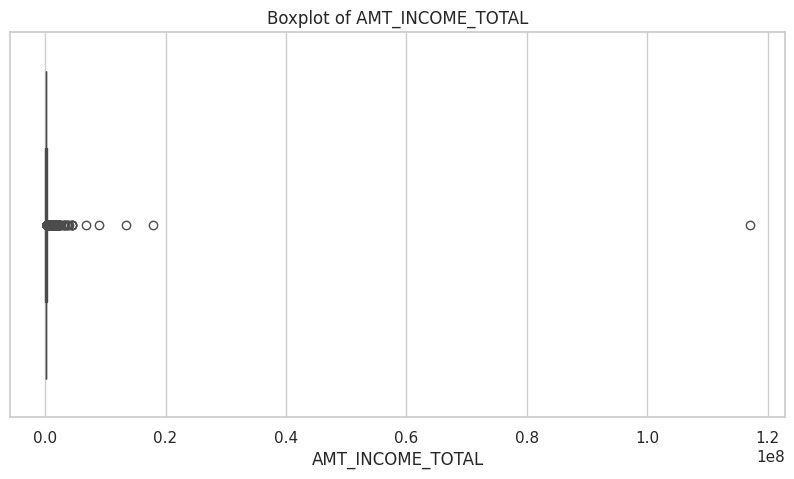

In [ ]:
#function to detect outliers
def detect_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR =Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
  return len(outliers)

#check outliers in key columns
for col in ['AMT_INCOME_TOTAL','AMT_CREDIT']:
    outliers_count=detect_outliers(application_data,col)
    print(f"Outliers in {col}: {outliers_count}")

#visual outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=application_data['AMT_INCOME_TOTAL'])
plt.title('Boxplot of AMT_INCOME_TOTAL')
plt.show()


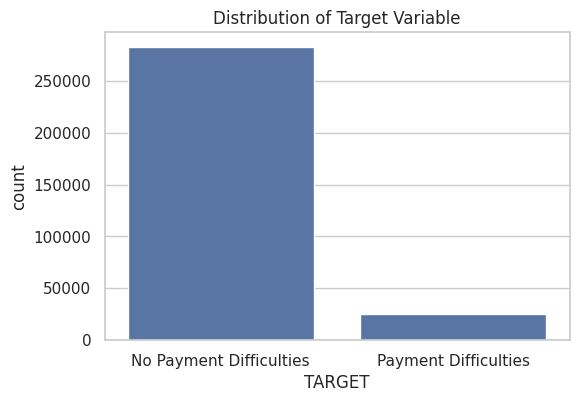

Target Distribution (%):
 TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


In [ ]:
#check target variables distribuction
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=application_data)
plt.title('Distribution of Target Variable')
plt.xticks([0,1],['No Payment Difficulties','Payment Difficulties'])
plt.show()

#calculate percantage
target_dist=application_data['TARGET'].value_counts(normalize=True)*100
print("Target Distribution (%):\n", target_dist)


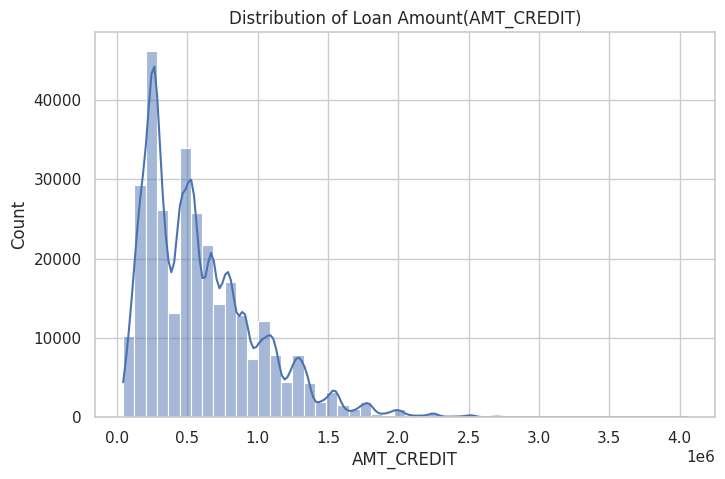

In [ ]:
#Histogram of AMT_CREDIT(loan amount)
plt.figure(figsize=(8,5))
sns.histplot(application_data['AMT_CREDIT'],bins=50, kde=True)
plt.title('Distribution of Loan Amount(AMT_CREDIT)')
plt.show()


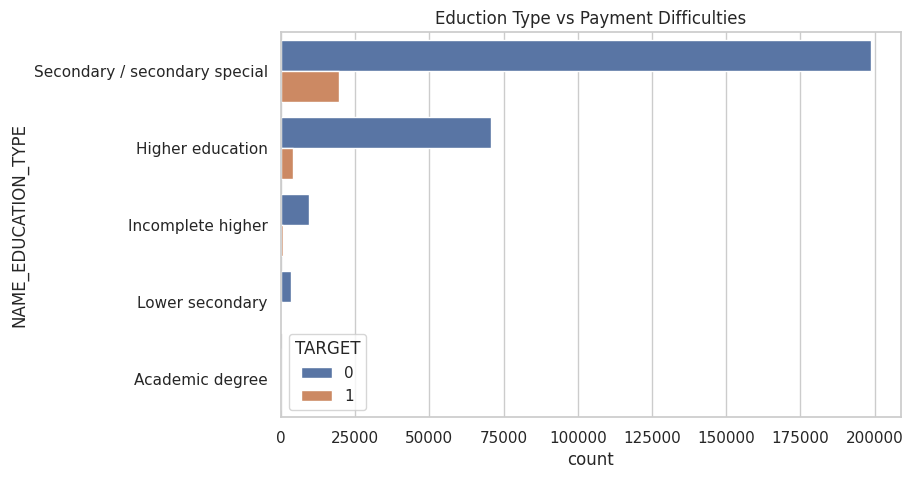

In [ ]:
#count plot of NAME_EDUCATION_TYPE
plt.figure(figsize=(8,5))
sns.countplot(y='NAME_EDUCATION_TYPE',hue='TARGET', data=application_data)
plt.title('Eduction Type vs Payment Difficulties')
plt.show()


Top 10  Features Correlation with Target:
 DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
Name: TARGET, dtype: float64


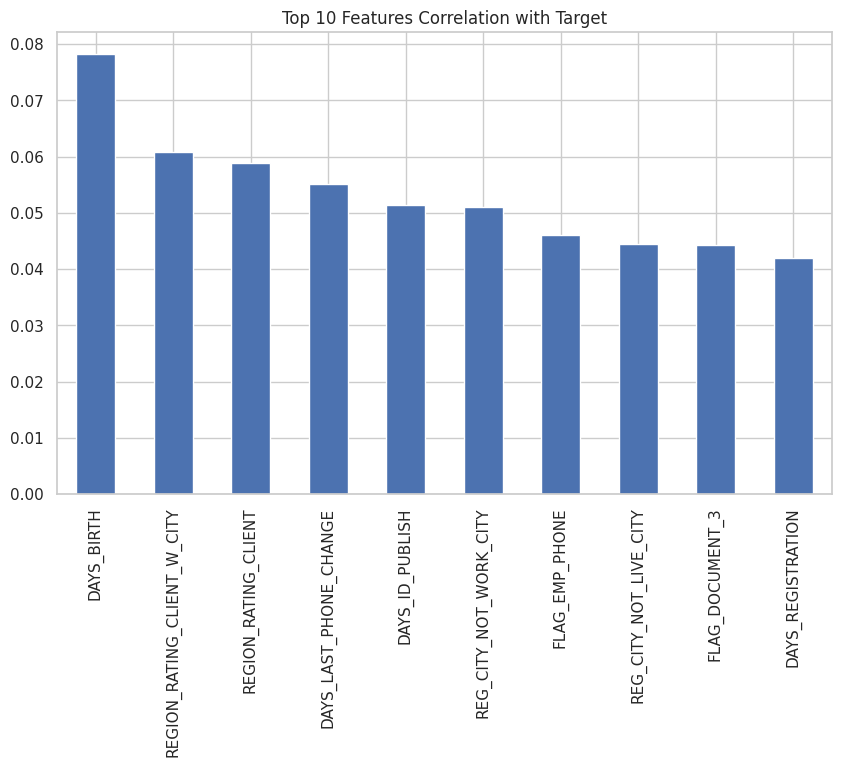

In [ ]:
#select numerical columns
numerical_data = application_data.select_dtypes(include=['int64','float64'])

#compute correlation with target
correlation=numerical_data.corr()['TARGET'].sort_values(ascending=False)

#top 10 correlation (excluding Target itself)
top_10_corr = correlation[1:11]
print("Top 10  Features Correlation with Target:\n",top_10_corr)

#visualize
plt.figure(figsize=(10,6))
top_10_corr.plot(kind='bar')
plt.title('Top 10 Features Correlation with Target')
plt.show()

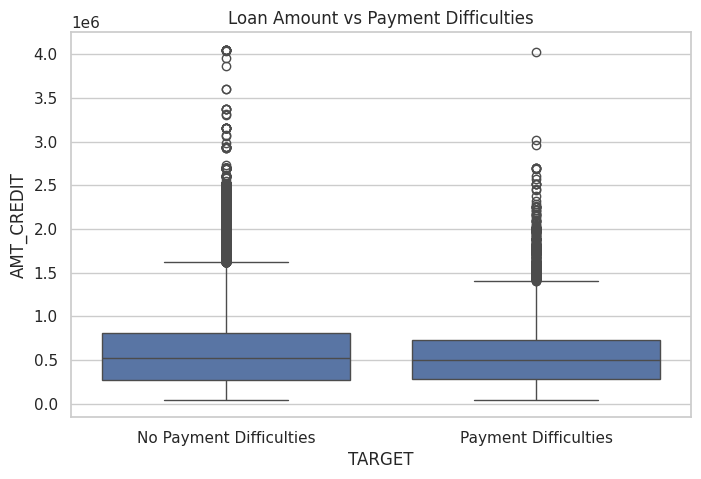

In [ ]:
#boxplot of AMT_CREDIT vs TARGET
plt.figure(figsize=(8,5))
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=application_data)
plt.title('Loan Amount vs Payment Difficulties')
plt.xticks ([0,1],['No Payment Difficulties','Payment Difficulties'])
plt.show()

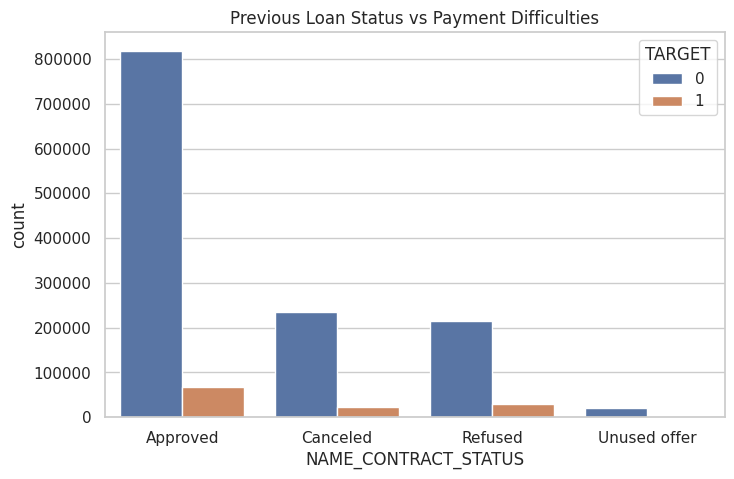

In [ ]:
#merge on SK_IS_CURR
merged_data=application_data.merge(previous_application_data[['SK_ID_CURR','NAME_CONTRACT_STATUS']],on='SK_ID_CURR',how='left')

#analyze previous loan status vs target
plt.figure(figsize=(8,5))
sns.countplot(x='NAME_CONTRACT_STATUS',hue='TARGET', data=merged_data)
plt.title('Previous Loan Status vs Payment Difficulties')
plt.show()

In [ ]:
#insights
print("KEY Insights:")
print("-Clients with lower education lavels (e.g.,Secondary) have a higher proportion of payment difficulties.")
print("-Older clients (higher Days_Birth) and those with better external scores (EXT_SOURCE_3) are less likely to default.")
print("-Previous loan refusals correlate with a higher risk of payment difficulties.")


KEY Insights:
-Clients with lower education lavels (e.g.,Secondary) have a higher proportion of payment difficulties.
-Older clients (higher Days_Birth) and those with better external scores (EXT_SOURCE_3) are less likely to default.
-Previous loan refusals correlate with a higher risk of payment difficulties.
